<a href="https://colab.research.google.com/github/hilya09/cybersafeguard/blob/master/train-model-collab/Phishing/Train_Model_Phishing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phishing URL Detection


## Modules dan Packages

In [ ]:
# pastikan versi scikit-learn == 1.2.2
# jika tidak sesuai, install versi scikit-learn yang sesuai
!pip show scikit-learn

Name: scikit-learn
Version: 1.2.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: fastai, imbalanced-learn, librosa, lightgbm, mlxtend, qudida, sklearn-pandas, yellowbrick


In [ ]:
import gdown
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns  
import time 

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nltk.tokenize import RegexpTokenizer  
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.pipeline import make_pipeline

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import joblib

In [ ]:
gdown.download_folder("https://drive.google.com/drive/u/0/folders/1ff6YnFUUJD0P89nDfjKQviRb57jayHC9")

Retrieving folder list


Processing file 1ZKaetf7Zh4WDSYnJyxjd7YcNuPy-lT8y phishing_site_urls.zip
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1ZKaetf7Zh4WDSYnJyxjd7YcNuPy-lT8y
To: /content/dataset-phishing/phishing_site_urls.zip
100%|██████████| 9.33M/9.33M [00:00<00:00, 22.7MB/s]
Download completed


['/content/dataset-phishing/phishing_site_urls.zip']

In [ ]:
with zipfile.ZipFile('/content/dataset-phishing/phishing_site_urls.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/train-model/phishing/')

In [ ]:
data = pd.read_csv("/content/train-model/phishing/phishing_site_urls.csv")

## Exploratory Data Analysis (EDA)

In [ ]:
data.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [ ]:
data.shape

(549346, 2)

In [ ]:
# Mengecek noise dan mendapatkan informasi mengenai daset
data.isnull().sum()

URL      0
Label    0
dtype: int64

In [ ]:
# Mendapatkan informasi 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [ ]:
# Membuat fungsi untuk mengubah label menjadi angka
def polaritas(teks):
  if teks =='good':
    return 1
  elif teks =='bad':
    return 0

In [ ]:
data['label_enc'] = data['Label'].apply(polaritas)

In [ ]:
print('Total Jumlah url:', data.shape[0], 'data\n')
print('terdiri dari (label):')
print('-- [1] Good\t\t:', data[data.label_enc == 1].shape[0], 'data')
print('-- [0] Bad\t\t:', data[data.label_enc == 0].shape[0], 'data\n')

Total Jumlah url: 549346 data

terdiri dari (label):
-- [1] Good		: 392924 data
-- [0] Bad		: 156422 data



<Axes: xlabel='Label', ylabel='count'>

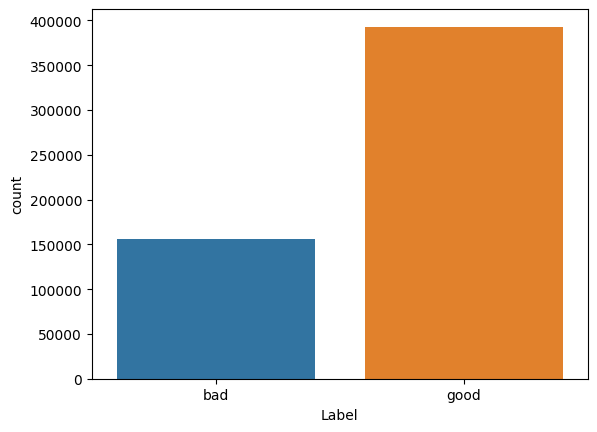

In [ ]:
sns.countplot(x='Label',data=data)

## Tokenisasi

In [ ]:
#Tokenisasi
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [ ]:
tokenizer.tokenize(data.URL[0]) # melakukan tokenisasi pada URL pertama di dataset

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [ ]:
# Tokenizing all the rows 
print('Getting words tokenized ...')
t0= time.perf_counter()
data['text_tokenized'] = data.URL.map(lambda t: tokenizer.tokenize(t))
t1 = time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words tokenized ...
Time taken 4.789123160000003 sec


In [ ]:
data.sample(5)

,URL,Label,label_enc,text_tokenized
395573,mylife.com/c-148060820,good,1,"[mylife, com, c]"
89208,www.owenink.com/ac/order.html,good,1,"[www, owenink, com, ac, order, html]"
445634,themalenude.com/gay/escorts/gay-escort-ty_latt...,good,1,"[themalenude, com, gay, escorts, gay, escort, ..."
291109,bigfishgames.com/download-games/13840/twisted-...,good,1,"[bigfishgames, com, download, games, twisted, ..."
111246,luxury-domains.com/business4/,bad,0,"[luxury, domains, com, business]"


## Stemming

In [ ]:
# Mengubah ke bentuk kata dasar
stemmer = SnowballStemmer("english") # choose a language

In [ ]:
# Getting all the stemmed words
print('Getting words stemmed ...')
t0= time.perf_counter()
data['text_stemmed'] = data['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words stemmed ...
Time taken 34.748111745 sec


In [ ]:
data.sample(5)

,URL,Label,label_enc,text_tokenized,text_stemmed
356276,ibabuzz.com/politics/2009/11/17/john-t-nejedly...,good,1,"[ibabuzz, com, politics, john, t, nejedly, to,...","[ibabuzz, com, polit, john, t, neje, to, run, ..."
49878,www.overseasbrokers.com/entertainment.html,good,1,"[www, overseasbrokers, com, entertainment, html]","[www, overseasbrok, com, entertain, html]"
253113,uk.linkedin.com/pub/william-baker/15/360/118,good,1,"[uk, linkedin, com, pub, william, baker]","[uk, linkedin, com, pub, william, baker]"
58789,www.cs.huji.ac.il/~tishby/,good,1,"[www, cs, huji, ac, il, tishby]","[www, cs, huji, ac, il, tishbi]"
243854,streema.com/radios/Estero_Sol_KSOL,good,1,"[streema, com, radios, Estero, Sol, KSOL]","[streema, com, radio, estero, sol, ksol]"


In [ ]:
# Joining all the stemmmed words.
print('Get joiningwords ...')
t0= time.perf_counter()
data['text_sent'] = data['text_stemmed'].map(lambda l: ' '.join(l))
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Get joiningwords ...
Time taken 0.16232241100000522 sec


In [ ]:
bad_sites = data[data.Label == 'bad']
good_sites = data[data.Label == 'good']

In [ ]:
bad_sites.head()

,URL,Label,label_enc,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,0,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,0,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,0,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,0,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,0,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [ ]:
good_sites.head()

,URL,Label,label_enc,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,1,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,1,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,1,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,1,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,1,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


In [ ]:
data.head()

,URL,Label,label_enc,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,0,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,0,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,0,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,0,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,0,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


## Ekstraksi fitur menjadi sebuah matrix

In [ ]:
#Ekstraksi Fitur menjadi sebuah matriks
cv = CountVectorizer()

In [ ]:
feature = cv.fit_transform(data.text_sent) #transform all text which we tokenize and stemed

In [ ]:
feature[:5].toarray() # convert sparse matrix into array to print transformed features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
import pickle
with open('feature.pickle', 'wb') as output:
  pickle.dump(feature, output)

In [ ]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(feature, data.label_enc)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create LR object
lr = LogisticRegression()

# Train algoritma
lr.fit(trainX,trainY)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
lr.score(testX,testY)

0.9649038496544995

In [ ]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

Training Accuracy : 0.9779567922059955
Testing Accuracy : 0.9649038496544995

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.96      0.94     36904
        Good       0.99      0.97      0.98    100433

    accuracy                           0.96    137337
   macro avg       0.95      0.96      0.96    137337
weighted avg       0.97      0.96      0.97    137337


CONFUSION MATRIX


<Axes: >

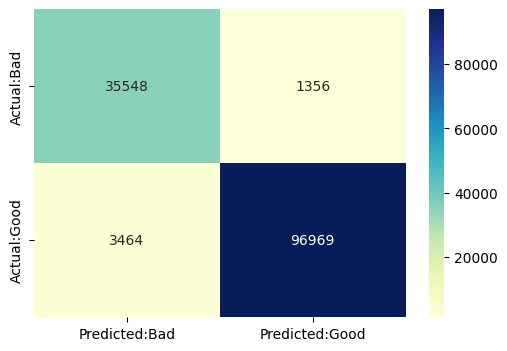

In [ ]:
# creating confusing matrix
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

## Multinomial NB


In [ ]:
from sklearn.naive_bayes import MultinomialNB 

# Create mnb object
mnb = MultinomialNB()

# Fit/Latih algoritma model mnb
mnb.fit(trainX,trainY)

MultinomialNB()

In [ ]:
mnb.score(testX,testY)

0.9576370533796428

In [ ]:
Scores_ml['MultinomialNB'] = np.round(mnb.score(testX,testY),2)

Training Accuracy : 0.9741534772298663
Testing Accuracy : 0.9576370533796428

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.92      0.93      0.92     38266
        Good       0.97      0.97      0.97     99071

    accuracy                           0.96    137337
   macro avg       0.95      0.95      0.95    137337
weighted avg       0.96      0.96      0.96    137337


CONFUSION MATRIX


<Axes: >

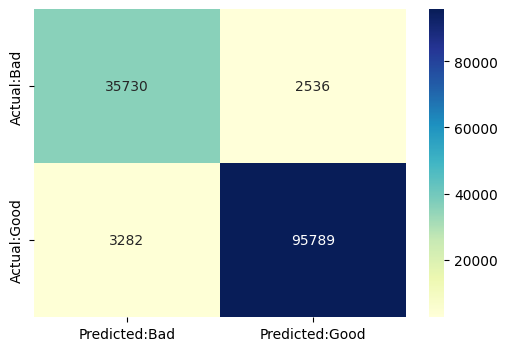

In [ ]:
print('Training Accuracy :',mnb.score(trainX,trainY))
print('Testing Accuracy :',mnb.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(mnb.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(mnb.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### Logistic Regression is the best fit model, Now we make sklearn pipeline using Logistic Regression

In [ ]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())

In [ ]:
trainX, testX, trainY, testY = train_test_split(data.URL, data.Label)

In [ ]:
pipeline_ls.fit(trainX,trainY)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression())])

In [ ]:
pipeline_ls.score(testX,testY)

0.966636813094796

Training Accuracy : 0.9799130601515986
Testing Accuracy : 0.966636813094796

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.94     36949
        Good       0.99      0.97      0.98    100388

    accuracy                           0.97    137337
   macro avg       0.95      0.97      0.96    137337
weighted avg       0.97      0.97      0.97    137337


CONFUSION MATRIX


<Axes: >

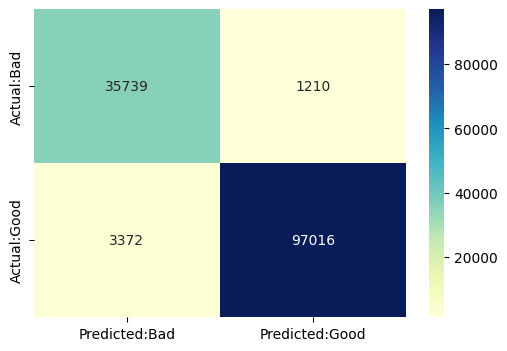

In [ ]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [ ]:
joblib.dump((pipeline_ls), "model_phishing_lr.model")

['model_phishing_lr.model']

In [ ]:
from joblib import load
loaded_model = load('model_phishing_lr.model')
result = loaded_model.score(testX,testY)
print(result)

0.966636813094796


## Try to predict

In [ ]:
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
predict_good = ['youtube.com/','www.kaggle.com/code/ashishkumarbehera/phishing-site-prediction','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
loaded_model = load('model_phishing_lr.model')

result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)
print("*"*30)
print(result2)

['bad' 'bad' 'bad' 'bad']
******************************
['good' 'good' 'good' 'good']
